In [1]:
#AML save importance scores IF inclusion optimus scrambler 
import keras
import keras.backend as K
from keras.datasets import mnist
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Dropout, Activation, Flatten, Input, Lambda
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Conv1D, MaxPooling1D, LSTM, ConvLSTM2D, GRU, BatchNormalization, LocallyConnected2D, Permute, TimeDistributed, Bidirectional
from keras.layers import Concatenate, Reshape, Conv2DTranspose, Embedding, Multiply, Activation

from functools import partial

from collections import defaultdict

import os
import pickle
import numpy as np

import scipy.sparse as sp
import scipy.io as spio

class MySequence :
    def __init__(self) :
        self.dummy = 1

keras.utils.Sequence = MySequence

import isolearn.io as isoio
import isolearn.keras as isol

import matplotlib.pyplot as plt

from sequence_logo_helper import dna_letter_at, plot_dna_logo

import shap
import tensorflow as tf


from optimusFunctions import *
import pandas as pd

Using TensorFlow backend.


In [2]:
#for formulation 2 graphing 
def returnXMeanLogits(e_train):
    #returns x mean logits for displayign the pwm difference for the version 2 networks 
    #Visualize background sequence distribution
    seq_e_train = one_hot_encode(e_train,seq_len=50)
    x_train = seq_e_train
    x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1], x_train.shape[2]))
    pseudo_count = 1.0
    x_mean = (np.sum(x_train, axis=(0, 1)) + pseudo_count) / (x_train.shape[0] + 4. * pseudo_count)
    x_mean_logits = np.log(x_mean / (1. - x_mean))
    return x_mean_logits, x_mean

In [3]:
#Gradient saliency/backprop visualization

import matplotlib.collections as collections
import operator
import matplotlib.pyplot as plt

import matplotlib.cm as cm
import matplotlib.colors as colors

import matplotlib as mpl
from matplotlib.text import TextPath
from matplotlib.patches import PathPatch, Rectangle
from matplotlib.font_manager import FontProperties
from matplotlib import gridspec
from matplotlib.ticker import FormatStrFormatter

def plot_importance_scores(importance_scores, ref_seq, figsize=(12, 2), score_clip=None, sequence_template='', plot_start=0, plot_end=96) :

    end_pos = ref_seq.find("#")
    
    fig = plt.figure(figsize=figsize)
    
    ax = plt.gca()
    
    if score_clip is not None :
        importance_scores = np.clip(np.copy(importance_scores), -score_clip, score_clip)
    
    max_score = np.max(np.sum(importance_scores[:, :], axis=0)) + 0.01

    for i in range(0, len(ref_seq)) :
        mutability_score = np.sum(importance_scores[:, i])
        dna_letter_at(ref_seq[i], i + 0.5, 0, mutability_score, ax)

    plt.sca(ax)
    plt.xlim((0, len(ref_seq)))
    plt.ylim((0, max_score))
    plt.axis('off')
    plt.yticks([0.0, max_score], [0.0, max_score], fontsize=16)
    
    for axis in fig.axes :
        axis.get_xaxis().set_visible(False)
        axis.get_yaxis().set_visible(False)
    
    plt.tight_layout()
    
    plt.show()


In [9]:
#background 
e_train = pd.read_csv("otherHalfOfHumanUTRs_UseForBackground.csv")
#print ("training: ", e_train.shape[0], " testing: ", x_test.shape[0])

#one hot encode with optimus encoders 
seq_e_train = one_hot_encode(e_train,seq_len=50)
x_mean_logits, x_mean = returnXMeanLogits(e_train)
seq_e_train = one_hot_encode(e_train,seq_len=50)
x_train = seq_e_train
x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1], x_train.shape[2]))

#Select background set of images for deepshap
background = x_train[np.random.choice(x_train.shape[0], 100, replace=False)]
background = np.squeeze(background)
print (background.shape)

#Define sequence template (APA Doubledope sublibrary)
sequence_template = 'N'*50
sequence_mask = np.array([1 if sequence_template[j] == 'N' else 0 for j in range(len(sequence_template))])

#Load Predictor

from keras.layers import Reshape

def _get_model(border_mode='same', inp_len=50, nodes=40, layers=3, filter_len=8, nbr_filters=120,
                dropout1=0, dropout2=0, dropout3=0, nb_epoch=3):
    ''' Build model archicture and fit.'''
    
    '''
    model = Sequential()
    if layers >= 1:
        model.add(Conv1D(activation="relu", input_shape=(inp_len, 4), padding=border_mode, filters=nbr_filters, kernel_size=filter_len))
    if layers >= 2:
        model.add(Conv1D(activation="relu", input_shape=(inp_len, 1), padding=border_mode, filters=nbr_filters, kernel_size=filter_len))
        #model.add(Dropout(dropout1))
    if layers >= 3:
        model.add(Conv1D(activation="relu", input_shape=(inp_len, 1), padding=border_mode, filters=nbr_filters, kernel_size=filter_len))
        #model.add(Dropout(dropout2))
    model.add(Flatten())

    model.add(Dense(nodes, kernel_initializer='zeros'))
    model.add(Activation('relu'))
    #model.add(Dropout(dropout3))
    
    model.add(Dense(1, kernel_initializer='zeros'))
    model.add(Activation('linear'))
    '''
    
    x = Input(shape=(50, 4), name='seq_input_copy')
    
    if layers >= 1:
        net = Conv1D(activation="relu", padding=border_mode, filters=nbr_filters, kernel_size=filter_len)(x)
    if layers >= 2:
        net = Conv1D(activation="relu", padding=border_mode, filters=nbr_filters, kernel_size=filter_len)(net)
    if layers >= 3:
        net = Conv1D(activation="relu", padding=border_mode, filters=nbr_filters, kernel_size=filter_len)(net)
    
    net = Flatten()(net)
    net = Dense(nodes, kernel_initializer='zeros')(net)
    net = Activation('relu')(net)
    #net = Dropout(dropout3)(net)
    y = Dense(1, activation='linear', kernel_initializer='zeros', name='mrl_copy')(net)
    #y = Activation('linear')(net)
    
    model = Model([x], [y])

    return model

predictor = _get_model(nb_epoch=3,border_mode='same', inp_len=50, nodes=40, layers=3, nbr_filters=120, filter_len=8, dropout1=0, dropout2=0,dropout3=0.2)
predictor.load_weights('optimusRetrainedMain.hdf5')
predictor.trainable = False
predictor.compile(optimizer=keras.optimizers.SGD(lr=0.1), loss='mean_squared_error')


(100, 50, 4)


In [12]:
def runDeepshapOnData(dataset_name, saveDir):
    #Load dataset for benchmarking 
    dataset_name = csv_to_open.replace(".csv", "")
    data_df = pd.read_csv(saveDir + csv_to_open) #open from scores folder 
    
    seq_e_test = one_hot_encode(data_df, seq_len=50)
    benchmarkSet_seqs = seq_e_test
    x_test = np.reshape(benchmarkSet_seqs, (benchmarkSet_seqs.shape[0], benchmarkSet_seqs.shape[1], benchmarkSet_seqs.shape[2]))
    
    #Execute DeepSHAP attribution method
    e = shap.DeepExplainer(predictor, background)
    shap_values = e.shap_values(x_test)

    importance_scores_test = np.zeros(shap_values[0].shape)
    importance_scores_test[:, :, :] = shap_values[0][:, :, :]
    importance_scores_test_signed = np.copy(importance_scores_test * x_test)
    importance_scores_test = np.abs(importance_scores_test * x_test)
    
    #Visualize a few perturbations
    encoder = isol.OneHotEncoder(50)
    score_clip = 0.5
    for plot_i in range(0, 3) :

        print("Test sequence " + str(plot_i) + ":")

        plot_dna_logo(x_test[plot_i, :, :], sequence_template=sequence_template, figsize=(14, 0.65), plot_start=0, plot_end=50)
        plot_importance_scores(importance_scores_test[plot_i,  :, :].T, encoder.decode(x_test[plot_i,  :, :]), figsize=(14, 0.65), score_clip=score_clip, sequence_template=sequence_template, plot_start=0, plot_end=50)

    #Save predicted importance scores
    model_name = saveDir + "deepshap_" + dataset_name
    np.save(model_name + "_importance_scores_test", importance_scores_test)
    
    #Save predicted importance scores
    model_name = saveDir + "deepshap_" + dataset_name
    np.save(model_name + "_importance_scores_test_signed", importance_scores_test_signed)



Test sequence 0:


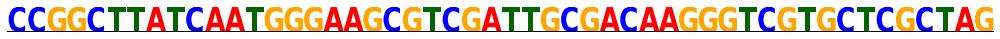

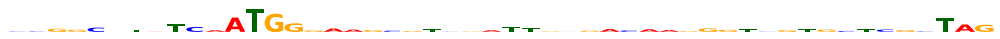

Test sequence 1:


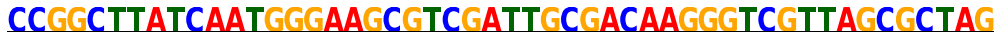

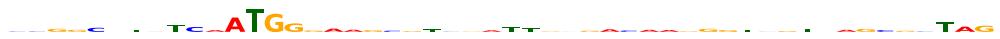

Test sequence 2:


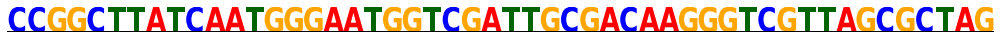

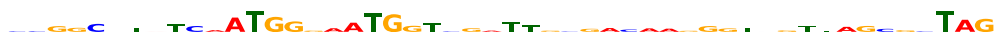

In [13]:
saveDir = "./"

allFiles = ["optimus5_synthetic_random_insert_if_uorf_1_start_1_stop_variable_loc_512.csv",
            "optimus5_synthetic_random_insert_if_uorf_1_start_2_stop_variable_loc_512.csv",
            "optimus5_synthetic_random_insert_if_uorf_2_start_1_stop_variable_loc_512.csv",
            "optimus5_synthetic_random_insert_if_uorf_2_start_2_stop_variable_loc_512.csv",
            "optimus5_synthetic_examples_3.csv"]

for csv_to_open in allFiles:
    runDeepshapOnData(csv_to_open, saveDir)
    